In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.ar_model import AutoReg
import time
import warnings
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import ticker
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore") # para ignorar os warnings de funcoes
plt.rcParams['figure.figsize'] = [16, 8] # para aumentar o tamanho das figuras
plt.rcParams.update({'font.size': 16}) # para aumentar a fonte das palavras nos graficos

## Lendo os dados
Código fornecido pelo Prof Helon Ayala

In [3]:
fname = os.getcwd() + '\\..\\data\\data3SS2009.mat'

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

# y

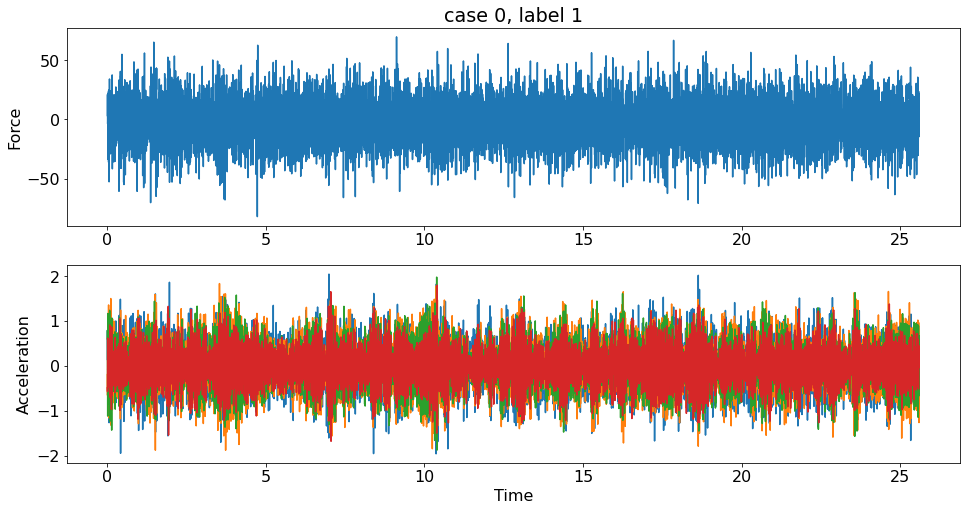

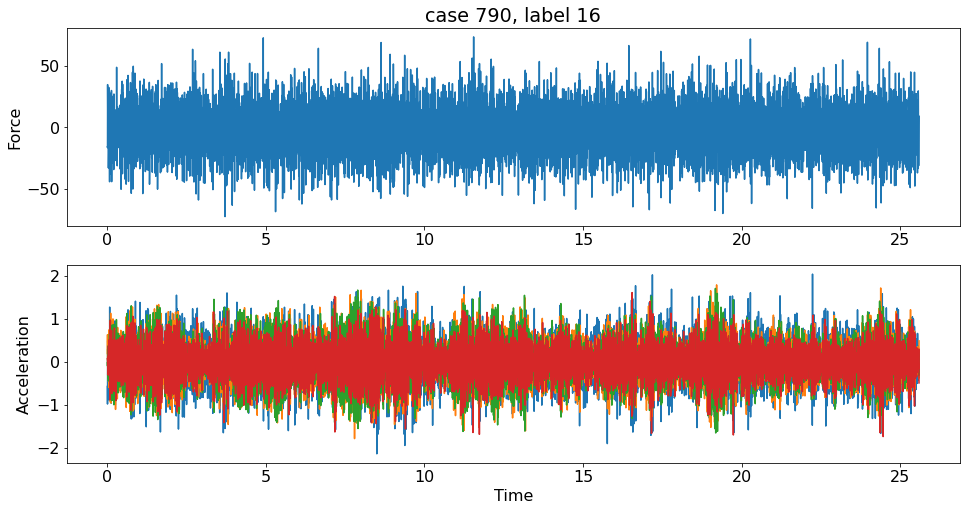

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time_vec = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time_vec,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time_vec,Ch2[:,case],time_vec,Ch3[:,case],time_vec,Ch4[:,case],time_vec,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## Ajustando modelos AR-X

In [5]:
t_ini = time.time()

lag = 29 # escolhido o 29 para que a matriz X1 tenha o formato 850x120
canais = [Ch2, Ch3, Ch4, Ch5]

X1 = []

for amostra in range(850): # loop sobre as amostras medidas (series temporais)
    
    parametros = []
    
    for canal in canais: # loop sobre os 4 canais de interesse
        
        ajuste = AutoReg(canal[:,amostra],lags=lag).fit()
        parametros.append(ajuste.params) # montando cada uma das 850 linhas da matriz
        
    X1.append(np.hstack(parametros)) # inserindo a linha na matriz

X1 = np.array(X1)

t_final = time.time()

print('Processo de ajuste dos modelos AR demorou {:.2f} segundos.'.format((t_final - t_ini)))

print('Formato da matriz X1: {}'.format(X1.shape))

Processo de ajuste dos modelos AR demorou 36.80 segundos.
Formato da matriz X1: (850, 120)


## Aplicando o PCA

Text(0, 0.5, 'Percentual da Variância Explicada (%)')

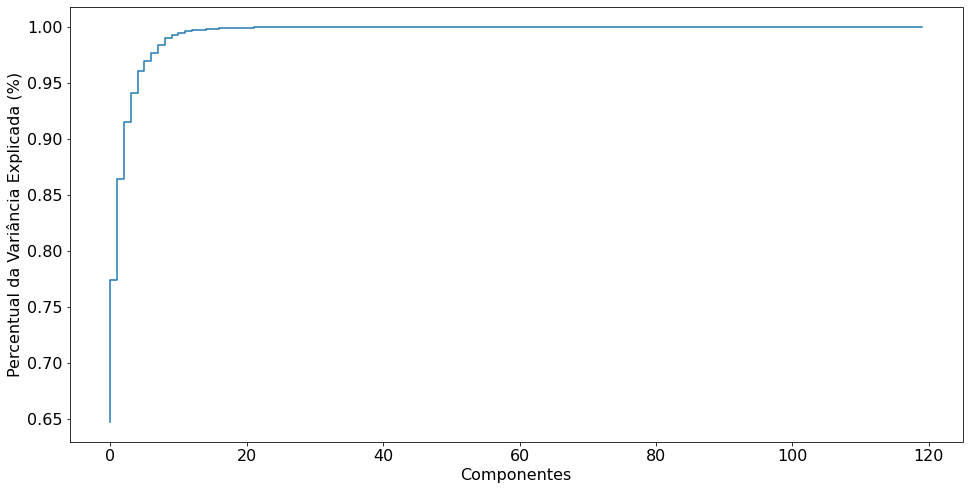

In [6]:
# Grafico que informa quanto da variancia e explicada utilizando X componentes

pca_full = PCA().fit(X1)

var_exp = pca_full.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variância Explicada (%)')


O gráfico acima mostra que grande parte das informações presente nos dados medidos pode ser bem representada com um número muito menor de componentes. Por exemplo, a curva se aproxima bastante de 100% a partir de 25 componentes.

Porcentagem da variancia explicada por cada componente:
Componente 1: 64.70%
Componente 2: 12.65%
Componente 3: 9.02%
Componente 4: 5.11%
Componente 5: 2.62%
Componente 6: 1.95%
Componente 7: 0.86%
Componente 8: 0.75%
Componente 9: 0.73%


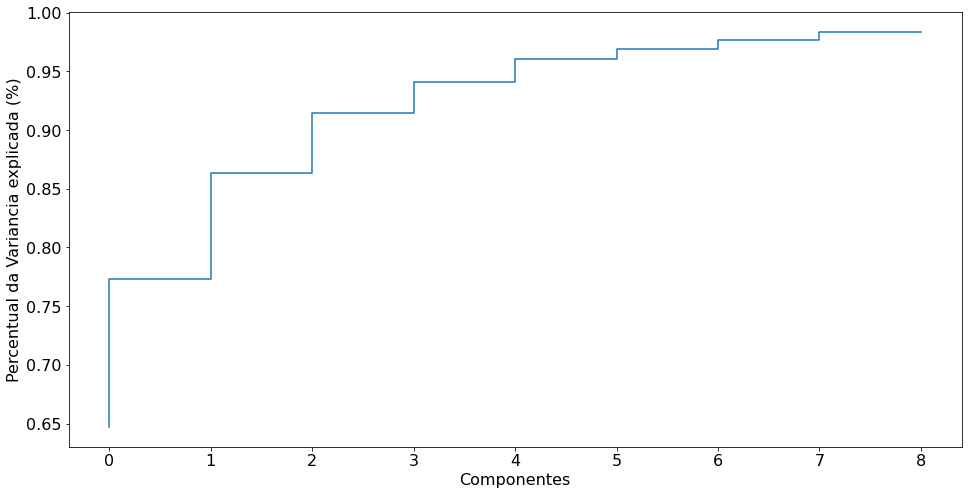

In [7]:
meta_variancia_exp = 0.98

pca = PCA(n_components = meta_variancia_exp, svd_solver = 'full').fit(X1)

var_exp = pca.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variancia explicada (%)')

print('Porcentagem da variancia explicada por cada componente:')
for i in range(len(var_exp)):
    print('Componente {}: {:.2f}%'.format(i+1, var_exp[i]*100))

X2 = pca.transform(X1)

Para garantir que 98% da variância consiga ser bem representada, basta utilizar 9 componentes, em que a capacidade que cada um tem para representar a variância nos dados está apresentada na célula acima.

## Normalizando as features

In [8]:
# def normaliza(X):
    
#     x_min = np.min(X)
#     x_max = np.max(X)
    
#     X_scaled = (X - x_min)/(x_max - x_min)
    
#     return X_scaled

In [9]:
# X1_scaled = normaliza(X1)
# print('min = {}'.format(np.min(X1_scaled)))
# print('max = {}'.format(np.max(X1_scaled)))

In [10]:
# X2_scaled = normaliza(X2)
# print('min = {}'.format(np.min(X2_scaled)))
# print('max = {}'.format(np.max(X2_scaled)))

Foi feita a tentativa de normalizar via a função "normaliza(X)" implementada acima. Porém, essa normalização simples não foi suficiente para melhorar o ajuste dos modelos no final do exercício. Por esse motivo, optou-se utilizar a função MinMaxScaler do pacote Sklearn.

De qualquer forma, é interessante notar como a forma em que a normalização é feita tem impacto direto no desempenho do modelo ajustado a partir dos dados normalizados.

In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))

X1_scaled = scaler.fit(X1).transform(X1)

X2_scaled = scaler.fit(X2).transform(X2)

## Visualizando e Comparando X1 e X2

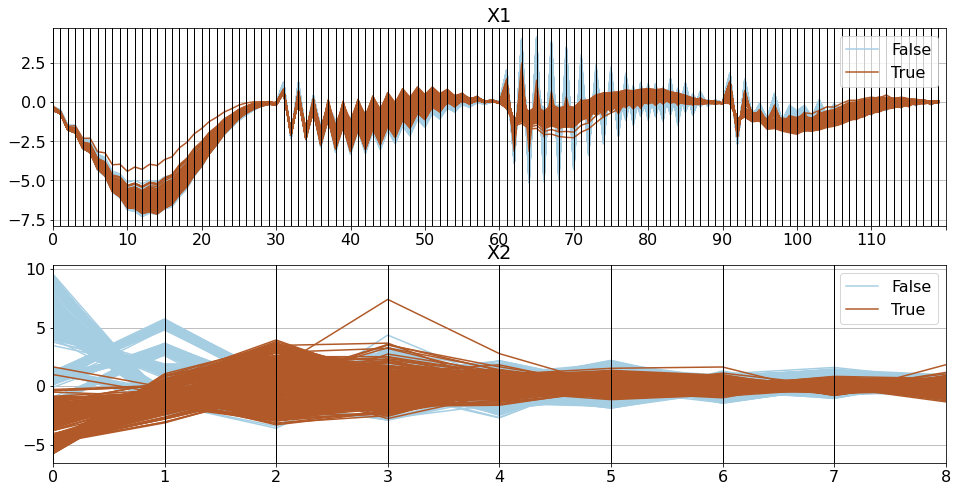

In [12]:
indDam = y > 9

dfX1 = pd.concat([pd.DataFrame(X1),pd.DataFrame({'target':indDam})],axis=1)
dfX2 = pd.concat([pd.DataFrame(X2),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

## Visualizando X1 e X2 normalizados

In [ ]:
indDam = y > 9

dfX1_scaled = pd.concat([pd.DataFrame(X1_scaled),pd.DataFrame({'target':indDam})],axis=1)
dfX2_scaled = pd.concat([pd.DataFrame(X2_scaled),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1_scaled,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1 - Normalizado')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2_scaled,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2 - Normalizado')

## Ajustando modelos lineares Softmax

In [ ]:
logreg_X1 = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X1, y)
score_X1 = logreg_X1.score(X1, y)
print('A acurácia média do modelo ajustado para X1 é de {:.4f};'.format(score_X1))

logreg_X2 = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X2, y)
score_X2 = logreg_X2.score(X2, y)
print('A acurácia média do modelo ajustado para X2 é de {:.4f};'.format(score_X2))

logreg_X1_scaled = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X1_scaled, y)
score_X1_scaled = logreg_X1_scaled.score(X1_scaled, y)
print('A acurácia média do modelo ajustado para X1 normalizado é de {:.4f};'.format(score_X1_scaled))

logreg_X2_scaled = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X2_scaled, y)
score_X2_scaled = logreg_X2_scaled.score(X2_scaled, y)
print('A acurácia média do modelo ajustado para X2 normalizado é de {:.4f};'.format(score_X2_scaled))